In [3]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# 1 - create engine:
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [4]:
query = """
SELECT *
FROM fact_neighborhood_price_analysis;
"""

df = pd.read_sql(query, engine)

df.head()

,neighborhood,price_2025,latitude,longitude,crime_count,distinct_offence_count,library_count,school_count,school_type_count,restaurant_count,park_count,park_type_count,station_count,total_entrances,total_routes,avg_fine_particles,avg_no2,cluster
0,Annadale,802312.506539,40.544550,-74.176532,48,14,0,1,1,3,5,2,0,0.0,0.0,6.181404,11.320946,0
1,Arden Heights,534218.504946,40.563700,-74.191603,32,14,0,0,0,0,2,1,0,0.0,0.0,6.181404,11.320946,0
2,Arrochar,755560.793354,40.598438,-74.072641,203,22,1,2,1,0,2,2,0,0.0,0.0,6.119536,10.464431,0
3,Astoria,743956.755533,40.772014,-73.930267,2927,44,3,13,5,314,16,5,4,15.0,8.0,7.254344,18.410157,1
4,Bath Beach,792107.819036,40.601850,-74.000501,1904,35,1,4,3,26,5,4,3,11.0,3.0,6.474938,16.388280,2


In [5]:
print(len(df))

197


#### Data preparation for clustering:


In [6]:
# remove identifier column (target)
df_model = df.drop(columns=["neighborhood"])

In [7]:
# check nulls 
df_model.isnull().sum()

price_2025                 0
latitude                   0
longitude                  0
crime_count                0
distinct_offence_count     0
library_count              0
school_count               0
school_type_count          0
restaurant_count           0
park_count                 0
park_type_count            0
station_count              0
total_entrances            0
total_routes               0
avg_fine_particles        61
avg_no2                   61
cluster                    0
dtype: int64

In [8]:
# fill NaNs in air quality columns with column means
for col in ["avg_fine_particles", "avg_no2"]:
    df_model[col].fillna(df_model[col].mean(), inplace=True)

# verify
df_model[["avg_fine_particles", "avg_no2"]].isnull().sum()

C:\Users\tiakh\AppData\Local\Temp\ipykernel_4168\834308049.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(df_model[col].mean(), inplace=True)


avg_fine_particles    0
avg_no2               0
dtype: int64

In [9]:
# SCALE FEATURES:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

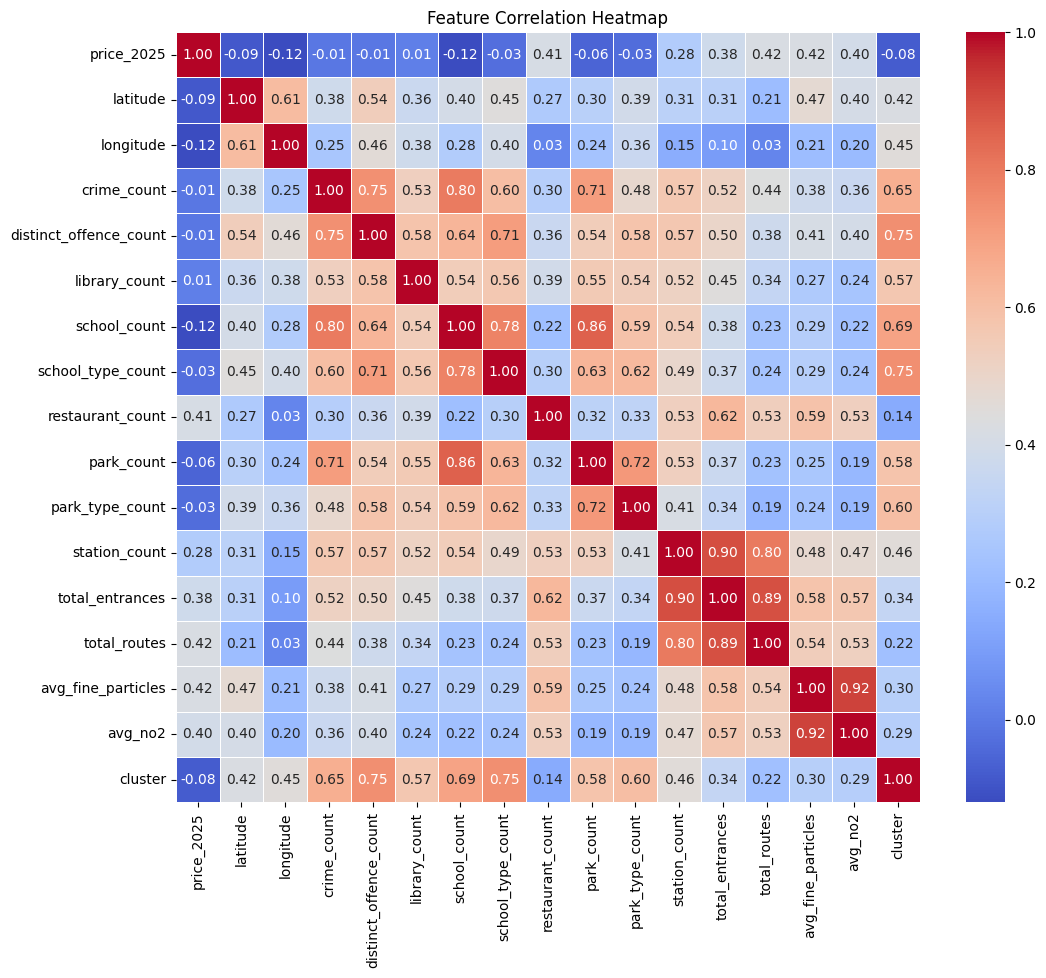

In [10]:
# heatmap:
corr = df_model.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

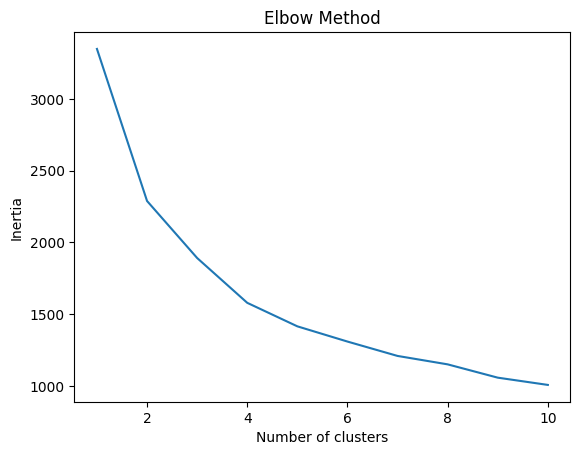

In [11]:
# Elbow method to choose number of clusters:

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [12]:
# KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

In [13]:
# quick check:
df["cluster"].value_counts()

cluster
2    81
1    77
3    28
0    11
Name: count, dtype: int64

In [14]:
df.groupby(["cluster", "neighborhood"]).mean()

price_2025   latitude  longitude  crime_count  \
cluster neighborhood                                                          
0       Bedford-Stuyvesant  1.049684e+06  40.683436 -73.941249       6667.0   
        Brownsville         6.490425e+05  40.665306 -73.912475       7468.0   
        Bushwick            9.393762e+05  40.694270 -73.918748       5452.0   
        East Harlem         6.650389e+05  40.794722 -73.942500       5594.0   
        East New York       6.441684e+05  40.666770 -73.882358       7180.0   
...                                  ...        ...        ...          ...   
3       Upper West Side     1.333412e+06  40.787045 -73.975416       2523.0   
        West Village        1.821514e+06  40.734186 -74.005580       1460.0   
        Williamsburg        1.281563e+06  40.714622 -73.953450       2385.0   
        Wingate             8.052765e+05  40.756595 -73.942650       1505.0   
        Woodside            5.599063e+05  40.745380 -73.905415       1056.0   

                            distinct_offence_count  library_count  \
cluster neighborhood                                                
0       Bedford-Stuyvesant                    46.0            2.0   
        Brownsville                           45.0            3.0   
        Bushwick                              42.0            3.0   
        East Harlem                           46.0            1.0   
        East New York                         45.0            4.0   
...                                            ...            ...   
3       Upper West Side                       40.0            2.0   
        West Village                          35.0            1.0   
        Williamsburg                          42.0            2.0   
        Wingate                               36.0            4.0   
        Woodside                              34.0            2.0   

                            school_count  school_type_count  restaurant_count  \
cluster neighborhood                                                            
0       Bedford-Stuyvesant          67.0                6.0              75.0   
        Brownsville                 64.0                6.0              12.0   
        Bushwick                    51.0                6.0             133.0   
        East Harlem                 57.0                8.0              67.0   
        East New York               49.0                6.0              17.0   
...                                  ...                ...               ...   
3       Upper West Side             25.0                5.0             289.0   
        West Village                 4.0                4.0             304.0   
        Williamsburg                32.0                6.0             362.0   
        Wingate                     21.0                5.0              73.0   
        Woodside                    17.0                3.0             175.0   

                            park_count  park_type_count  station_count  \
cluster neighborhood                                                     
0       Bedford-Stuyvesant        47.0              6.0            6.0   
        Brownsville               52.0              8.0           12.0   
        Bushwick                  32.0              5.0            8.0   
        East Harlem               26.0              5.0            4.0   
        East New York             50.0              6.0            8.0   
...                                ...              ...            ...   
3       Upper West Side           11.0              7.0            8.0   
        West Village              13.0              6.0            3.0   
        Williamsburg              42.0              8.0           11.0   
        Wingate                   12.0              6.0           11.0   
        Woodside                  21.0              5.0            8.0   

                            total_entrances  total_routes  avg_fine_particles  \
cluste

In [16]:
df.dtypes


neighborhood               object
price_2025                float64
latitude                  float64
longitude                 float64
crime_count                 int64
distinct_offence_count      int64
library_count               int64
school_count                int64
school_type_count           int64
restaurant_count            int64
park_count                  int64
park_type_count             int64
station_count               int64
total_entrances           float64
total_routes              float64
avg_fine_particles        float64
avg_no2                   float64
cluster                     int32
dtype: object

In [17]:
df_model.groupby(["cluster"]).mean() 

,price_2025,latitude,longitude,crime_count,distinct_offence_count,library_count,school_count,school_type_count,restaurant_count,park_count,park_type_count,station_count,total_entrances,total_routes,avg_fine_particles,avg_no2
cluster,,,,,,,,,,,,,,,,
0,7.815484e+05,40.641809,-74.021743,283.280488,20.865854,0.402439,2.414634,1.573171,7.365854,3.073171,2.195122,0.414634,1.170732,0.573171,6.501329,14.552847
1,1.403780e+06,40.731571,-73.976251,2107.714286,36.571429,1.678571,13.035714,3.857143,209.964286,10.928571,4.678571,6.000000,30.321429,18.428571,7.393332,20.094256
2,7.378611e+05,40.722515,-73.893951,1673.789474,37.118421,1.434211,13.263158,4.171053,34.986842,8.657895,4.789474,2.578947,9.250000,4.118421,6.748162,16.275811
3,6.906080e+05,40.769094,-73.917890,6231.636364,45.909091,2.454545,50.818182,6.454545,47.636364,34.636364,7.090909,6.090909,20.000000,9.363636,6.951152,17.002274


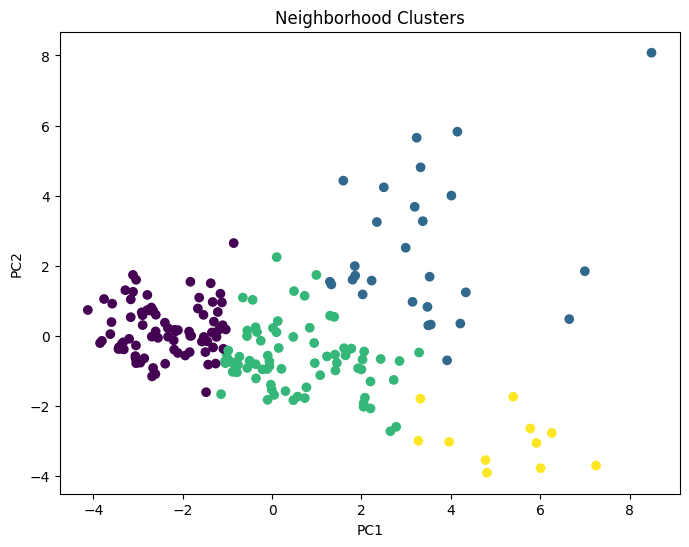

In [ ]:
# visualizations:
 
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=df["cluster"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Neighborhood Clusters")
plt.show()